In [0]:
import os
import cv2
import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from PIL import Image
from sklearn.utils import shuffle
import tensorflow as tf

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = os.path.join("/content/drive/My Drive/Face_Data")
!ls "/content/drive/My Drive/Face_Data"

Train_dir = base_dir + '/Train/'
Test_dir = base_dir + '/Test/'
Valid_dir = base_dir + "/Validation/"

nb_train_samples = sum([len(files) for _, _, files in os.walk(Train_dir)])
nb_validation_samples = sum([len(files) for _, _, files in os.walk(Valid_dir)])
nb_test_samples = sum([len(files) for _, _, files in os.walk(Test_dir)])
total_nb_samples = nb_train_samples + nb_validation_samples + nb_test_samples

print(' - # of trained samples: ', nb_train_samples, '\n - # of validation samples: ', nb_validation_samples,
      '\n - # of test samples: ', nb_test_samples,
       '\n - total # of samples: ', total_nb_samples, '\n - train ratio:', round(nb_train_samples/total_nb_samples*100, 2),
      '\n - validation ratio:', round(nb_validation_samples/total_nb_samples*100, 2),
      '\n - test ratio:', round(nb_test_samples/total_nb_samples*100, 2),)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Test  Train  Validation
 - # of trained samples:  788 
 - # of validation samples:  181 
 - # of test samples:  171 
 - total # of samples:  1140 
 - train ratio: 69.12 
 - validation ratio: 15.88 
 - test ratio: 15.0


In [0]:
class_names = ['Dumbledore', 'Hagrid', 'Harry', 'Hermione', 'Malfoy', 'Ron']

class_names_label = {class_name : i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

IMAGE_SIZE = (90, 140)

## **Load the data**

In [0]:
def load_data():
  datasets = [Train_dir, Valid_dir, Test_dir]
  output = []
  
  for dataset in datasets:
    Images = []
    Labels = []

    print("Loading {}".format(dataset))

    for folder in os.listdir(dataset):
      curr_label = class_names_label[folder]

      for file in os.listdir(os.path.join(dataset, folder)):
        img_path = os.path.join(os.path.join(dataset, folder), file)

        curr_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        #Whether or not there is bad file, print that image_path
        try:
          curr_img = cv2.resize(curr_img, IMAGE_SIZE)
        except cv2.error as e:
          print(img_path, 'Invalid Frame!')
        cv2.waitKey()  

        Images.append(curr_img)
        Labels.append(curr_label)

    Images = np.array(Images)
    Labels = np.array(Labels)
    output.append((Images, Labels))
  return output  

In [0]:
(train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels) = load_data()

Loading /content/drive/My Drive/Face_Data/Train/
Loading /content/drive/My Drive/Face_Data/Validation/
Loading /content/drive/My Drive/Face_Data/Test/


In [0]:
print ("Number of Training Examples: " + str(train_labels.shape[0]))
print ("Number of Validation Examples : " + str(valid_images.shape[0]))
print ("Number of Testing Examples: " + str(test_labels.shape[0]))
print ("Each image is of size: " + str(train_images.shape[0:]))

print("Size of Test image : " + str(test_images.shape[0:]))

Number of Training Examples: 788
Number of Validation Examples : 181
Number of Testing Examples: 171
Each image is of size: (788, 140, 90)
Size of Test image : (171, 140, 90)


## **Data Preprocessing**

In [0]:
x_train = train_images.reshape((788, 140, 90, 1))
x_valid = valid_images.reshape((181, 140, 90, 1))
x_test = test_images.reshape((test_images.shape[0], 140, 90, 1))

train_img = x_train / 255.0 
valid_img = x_valid / 255.0
test_img = x_test / 255.0

y_train = tf.keras.utils.to_categorical(train_labels)
y_valid = tf.keras.utils.to_categorical(valid_labels)
y_test = tf.keras.utils.to_categorical(test_labels)

## **Best Original Model with Augmented Data**


In [0]:
train_datagen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    color_mode='grayscale',
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator = validation_datagen.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   color_mode='grayscale',
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator = test_datagen.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  color_mode='grayscale',
                                                  batch_size = 171 ,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
K.clear_session()
model_data_aug = Sequential()
model_data_aug.add( Conv2D(32, (3, 3), activation= 'relu', input_shape = train_img[0, :, :, :].shape))
model_data_aug.add(BatchNormalization())
model_data_aug.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_data_aug.add(MaxPool2D(pool_size=(2,2)))
model_data_aug.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_data_aug.add(MaxPool2D(pool_size=(2,2)))
model_data_aug.add(Dropout(0.25))
model_data_aug.add( Flatten() )
model_data_aug.add( Dense(128, activation = 'relu' ) )
model_data_aug.add( Dense(6, activation = 'sigmoid' ) )
model_data_aug.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 88, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 138, 88, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 86, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 20, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 33, 20, 32)        0

In [0]:
model_data_aug.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
callback_a = ModelCheckpoint(filepath = 'my_best_model.hdf1', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
history_aug = model_data_aug.fit_generator(train_generator, 
                                       steps_per_epoch=100,
                                       epochs=100,
                                       callbacks=[callback_a, callback_b],
                                       validation_data=validation_genrator,
                                       validation_steps =valid_images.shape[0] / 10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
 34/100 [=========>....................] - ETA: 4s - loss: 0.4380 - accuracy: 0.4132

In [0]:
plt.plot(history_aug.history['accuracy'])
plt.plot(history_aug.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_aug, validation_acc_aug = model_data_aug.evaluate( valid_img, y_valid )
print( 'validation_acc:', validation_acc_aug)

validation_loss_aug2, validation_acc_aug2 = model_data_aug.evaluate_generator(validation_genrator, steps=10)
print('validation_acc of gen:', validation_acc_aug2)

In [0]:
test_loss_aug, test_acc_aug = model_data_aug.evaluate_generator(test_generator, steps=30)
print('test_acc:', test_acc_aug)

test_loss_aug_r, test_acc_aug_r = model_data_aug.evaluate(test_img, y_test, verbose=1)
print(test_acc_aug_r)

##**VGG16 pre-trained Model**

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen_VGG16 = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen_VGG16 = ImageDataGenerator(rescale=1./255)
test_datagen_VGG16 = ImageDataGenerator(rescale=1./255)

train_generator_VGG16 = train_datagen_VGG16.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator_VGG16 = validation_datagen_VGG16.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator_VGG16 = test_datagen_VGG16.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  batch_size = 171,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
conv_base_vgg16 = VGG16(weights='imagenet', include_top = False, input_shape=(140,90,3))

In [0]:
for layer in conv_base_vgg16.layers:
  layer.trainable = False

## **VGG16 without the Dropout in the last layers**

In [0]:
K.clear_session()
vgg16_model = models.Sequential()
vgg16_model.add(conv_base_vgg16)
vgg16_model.add(layers.Flatten())
vgg16_model.add(layers.Dense(256, activation='relu'))
vgg16_model.add(layers.Dense(6, activation='sigmoid'))

vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 15,765,062
Trainable params: 1,050,374
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
callback_a = ModelCheckpoint(filepath = 'my_best_model.hdf1', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
vgg16_model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
history = vgg16_model.fit_generator(train_generator_VGG16, 
                                    steps_per_epoch=100,
                                    epochs=100,
                                    callbacks=[callback_a, callback_b],
                                    validation_data=validation_genrator_VGG16,
                                    validation_steps=valid_images.shape[0] / 10
                                  )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.6741
Epoch 00001: val_loss improved from inf to 0.17425, saving model to my_best_model.hdf1
100/100 [==============================] - 15s 149ms/step - loss: 0.2720 - accuracy: 0.6741 - val_loss: 0.1742 - val_accuracy: 0.7956
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1562 - accuracy: 0.8384
Epoch 00002: val_loss improved from 0.17425 to 0.15853, saving model to my_best_model.hdf1
100/100 [==============================] - 13s 135ms/step - loss: 0.1553 - accuracy: 0.8391 - val_loss: 0.1585 - val_accuracy: 0.8177
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.8644
Epoch 00003: val_loss improved from 0.15853 to 0.09263, saving model to my_best_model.hdf1
100/100 [==============================] - 13s 130ms/step - loss: 0.1296 - accuracy: 0.8644 - va

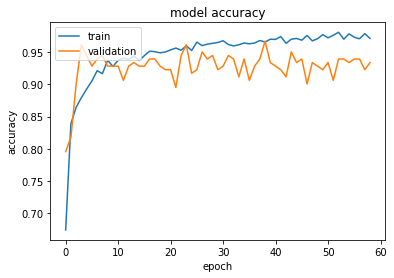

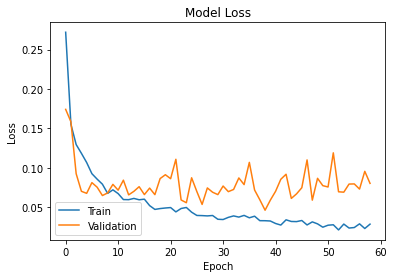

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss') 
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_vgg16, validation_acc_vgg16 = vgg16_model.evaluate_generator(validation_genrator_VGG16, steps=10)
print( 'validation_acc:', validation_acc_vgg16)

Instructions for updating:
Please use Model.evaluate, which supports generators.
validation_acc: 0.9337016344070435


In [0]:
test_loss_vgg16, test_acc_vgg16 = vgg16_model.evaluate_generator(test_generator_VGG16, steps=30)
print('test_acc:', test_acc_vgg16)

test_acc: 0.8830409646034241


###**VGG16 with Dropout Layer**

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen_VGG16_1 = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen_VGG16_1 = ImageDataGenerator(rescale=1./255)
test_datagen_VGG16_1 = ImageDataGenerator(rescale=1./255)

train_generator_VGG16_1 = train_datagen_VGG16_1.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator_VGG16_1 = validation_datagen_VGG16_1.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator_VGG16_1 = test_datagen_VGG16_1.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  batch_size = 171,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
K.clear_session()
vgg16_model_1 = models.Sequential()
vgg16_model_1.add(conv_base_vgg16)
vgg16_model_1.add(layers.Flatten())
vgg16_model_1.add(layers.Dense(256, activation='relu'))
vgg16_model_1.add(layers.Dropout(0.5))
vgg16_model_1.add(layers.Dense(6, activation='sigmoid'))

vgg16_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 15,765,062
Trainable params: 1,050,374
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
callback_c = ModelCheckpoint(filepath = 'my_best_model.hdf2', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_d = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
vgg16_model_1.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
history_1 = vgg16_model_1.fit_generator(train_generator_VGG16_1, 
                                    steps_per_epoch=100,
                                    epochs=100,
                                    callbacks=[callback_c, callback_d],
                                    validation_data=validation_genrator_VGG16_1,
                                    validation_steps=valid_images.shape[0] / 10
                                  )

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.3538 - accuracy: 0.5309
Epoch 00001: val_loss improved from inf to 0.20135, saving model to my_best_model.hdf2
100/100 [==============================] - 13s 125ms/step - loss: 0.3538 - accuracy: 0.5309 - val_loss: 0.2014 - val_accuracy: 0.8011
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2309 - accuracy: 0.7255
Epoch 00002: val_loss improved from 0.20135 to 0.14273, saving model to my_best_model.hdf2
100/100 [==============================] - 13s 126ms/step - loss: 0.2308 - accuracy: 0.7245 - val_loss: 0.1427 - val_accuracy: 0.8508
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.7621
Epoch 00003: val_loss improved from 0.14273 to 0.13346, saving model to my_best_model.hdf2
100/100 [==============================] - 13s 125ms/step - loss: 0.2012 - accuracy: 0.7621 - val_loss: 0.1335 - val_accuracy: 0.8508
Epoch 4/100
 99/100 [=================

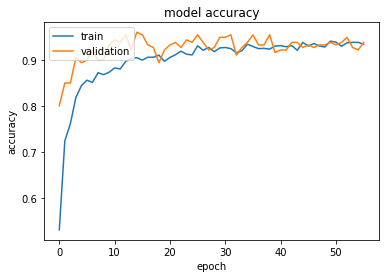

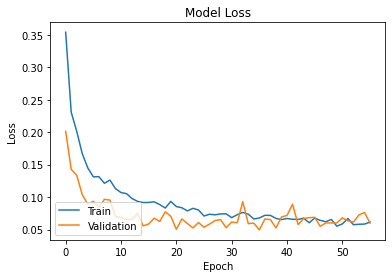

In [0]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_vgg16_1, validation_acc_vgg16_1 = vgg16_model_1.evaluate_generator(validation_genrator_VGG16_1, steps=10)
print( 'validation_acc:', validation_acc_vgg16_1)

validation_acc: 0.939226508140564


In [0]:
test_loss_vgg16_1, test_acc_vgg16_1 = vgg16_model_1.evaluate_generator(test_generator_VGG16_1, steps=30)
print('test_acc:', test_acc_vgg16_1)

test_acc: 0.8538011908531189


## **ResNet50**

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen_ResNet50 = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen_ResNet50 = ImageDataGenerator(rescale=1./255)
test_datagen_ResNet50 = ImageDataGenerator(rescale=1./255)

train_generator_ResNet50 = train_datagen_ResNet50.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator_ResNet50 = validation_datagen_ResNet50.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator_ResNet50 = test_datagen_ResNet50.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  batch_size = 171 ,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
from tensorflow.keras.applications import ResNet50
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(140, 90, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [0]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 90, 3)] 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 146, 96, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 70, 45, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 70, 45, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
for layer in resnet_model.layers:
  layer.trainable = False

In [0]:
K.clear_session()
resnet50_model = models.Sequential()
resnet50_model.add(resnet_model)
resnet50_model.add(layers.Flatten())
resnet50_model.add(layers.Dense(256, activation='relu'))
resnet50_model.add(layers.Dense(6, activation='sigmoid'))

resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 3, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 30720)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               7864576   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 31,453,830
Trainable params: 7,866,118
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
callback_e = ModelCheckpoint(filepath = 'my_best_model.hdf3', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_f = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
resnet50_model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
history_resnet50 = resnet50_model.fit_generator(train_generator_ResNet50, 
                                    steps_per_epoch=100,
                                    epochs=100,
                                    callbacks=[callback_e, callback_f],
                                    validation_data=validation_genrator_ResNet50,
                                    validation_steps=valid_images.shape[0] / 10
                                  )

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.4601 - accuracy: 0.2667
Epoch 00001: val_loss improved from inf to 0.44696, saving model to my_best_model.hdf3
100/100 [==============================] - 14s 136ms/step - loss: 0.4601 - accuracy: 0.2667 - val_loss: 0.4470 - val_accuracy: 0.2762
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.4265 - accuracy: 0.3190
Epoch 00002: val_loss improved from 0.44696 to 0.39626, saving model to my_best_model.hdf3
100/100 [==============================] - 13s 128ms/step - loss: 0.4260 - accuracy: 0.3198 - val_loss: 0.3963 - val_accuracy: 0.3315
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.3878 - accuracy: 0.4130
Epoch 00003: val_loss improved from 0.39626 to 0.37783, saving model to my_best_model.hdf3
100/100 [==============================] - 13s 129ms/step - loss: 0.3878 - accuracy: 0.4130 - val_loss: 0.3778 - val_accuracy: 0.4309
Epoch 4/100
 99/100 [=================

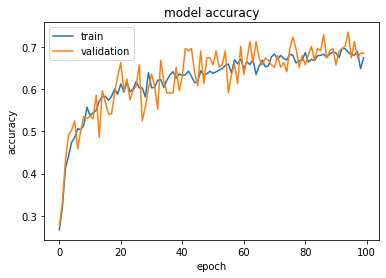

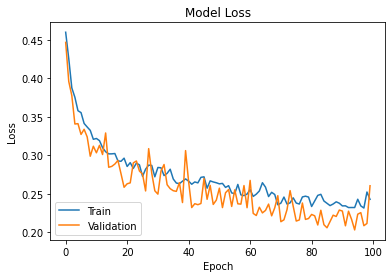

In [0]:
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_Res, validation_acc_Res = resnet50_model.evaluate_generator(validation_genrator_ResNet50, steps=10)
print( 'validation_acc:', validation_acc_Res)

validation_acc: 0.6850828528404236


In [0]:
test_loss_Res, test_acc_Res = resnet50_model.evaluate_generator(test_generator_ResNet50, steps=30)
print('test_acc:', test_acc_Res)

test_acc: 0.6783625483512878


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen_ResNet50_1= ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen_ResNet50_1 = ImageDataGenerator(rescale=1./255)
test_datagen_ResNet50_1 = ImageDataGenerator(rescale=1./255)

train_generator_ResNet50_1 = train_datagen_ResNet50_1.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator_ResNet50_1 = validation_datagen_ResNet50_1.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator_ResNet50_1 = test_datagen_ResNet50_1.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  batch_size = 171 ,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
K.clear_session()
resnet50_model_1 = models.Sequential()
resnet50_model_1.add(resnet_model)
resnet50_model_1.add(layers.Flatten())
resnet50_model_1.add(layers.Dense(256, activation='relu'))
resnet50_model_1.add(layers.Dropout(0.5))
resnet50_model_1.add(layers.Dense(6, activation='sigmoid'))

resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 3, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 30720)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               7864576   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 31,453,830
Trainable params: 7,866,118
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
callback_g = ModelCheckpoint(filepath = 'my_best_model.hdf3', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_h = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
resnet50_model_1.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
history_resnet50_1 = resnet50_model_1.fit_generator(train_generator_ResNet50_1, 
                                    steps_per_epoch=100,
                                    epochs=100,
                                    callbacks=[callback_g, callback_h],
                                    validation_data=validation_genrator_ResNet50_1,
                                    validation_steps=valid_images.shape[0] / 10
                                  )

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.5069 - accuracy: 0.1847
Epoch 00001: val_loss did not improve from 0.20323
100/100 [==============================] - 14s 137ms/step - loss: 0.5069 - accuracy: 0.1847 - val_loss: 0.4490 - val_accuracy: 0.1768
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.4745 - accuracy: 0.2071
Epoch 00002: val_loss did not improve from 0.20323
100/100 [==============================] - 13s 130ms/step - loss: 0.4744 - accuracy: 0.2077 - val_loss: 0.4417 - val_accuracy: 0.3812
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.4702 - accuracy: 0.2232
Epoch 00003: val_loss did not improve from 0.20323
100/100 [==============================] - 13s 133ms/step - loss: 0.4702 - accuracy: 0.2232 - val_loss: 0.4352 - val_accuracy: 0.3039
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 0.4580 - accuracy: 0.2638
Epoch 00004: val_loss did not improve from 0.20323
100/10

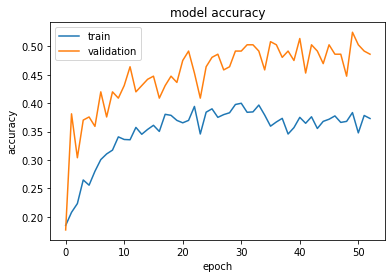

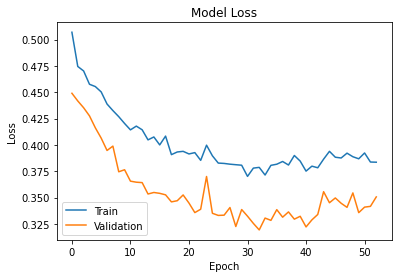

In [0]:
plt.plot(history_resnet50_1.history['accuracy'])
plt.plot(history_resnet50_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_resnet50_1.history['loss'])
plt.plot(history_resnet50_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_Res_1, validation_acc_Res_1 = resnet50_model_1.evaluate_generator(validation_genrator_ResNet50, steps=10)
print( 'validation_acc:', validation_acc_Res_1)

validation_acc: 0.4861878454685211


In [0]:
test_loss_Res_1, test_acc_Res_1 = resnet50_model_1.evaluate_generator(test_generator_ResNet50, steps=30)
print('test_acc:', test_acc_Res_1)

test_acc: 0.5438596606254578


## **Inception Network**

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen_inception = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen_inception = ImageDataGenerator(rescale=1./255)
test_datagen_inception = ImageDataGenerator(rescale=1./255)

train_generator_inception = train_datagen_inception.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator_inception = validation_datagen_inception.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator_inception = test_datagen_inception.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  batch_size = 171,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
from tensorflow.keras.applications import InceptionV3

inception_model =InceptionV3(weights='imagenet', include_top = False, input_shape = (140,90, 3))
inception_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 90, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 69, 44, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 69, 44, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 69, 44, 32)   0           batch_normalization[0][0]        
______________________

In [0]:
for layer in inception_model.layers:
  layer.trainable = False

In [0]:
K.clear_session()
x = layers.Flatten()(inception_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

model_inception = Model(inception_model.input, x)
model_inception.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
callback_I = ModelCheckpoint(filepath = 'my_best_model.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_J = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
history_inception = model_inception.fit_generator(train_generator_inception,
                                                  steps_per_epoch=100,
                                                  epochs=100,
                                                  callbacks=[callback_I, callback_J], 
                                                  validation_data=validation_genrator_inception,
                                                  validation_steps=valid_images.shape[0] / 10                             
                                                )

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.5653 - accuracy: 0.8269
Epoch 00001: val_loss improved from inf to 0.45510, saving model to my_best_model.hdf5
100/100 [==============================] - 15s 152ms/step - loss: 0.5653 - accuracy: 0.8269 - val_loss: 0.4551 - val_accuracy: 0.8333
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.4558 - accuracy: 0.8333
Epoch 00002: val_loss improved from 0.45510 to 0.45468, saving model to my_best_model.hdf5
100/100 [==============================] - 13s 133ms/step - loss: 0.4558 - accuracy: 0.8333 - val_loss: 0.4547 - val_accuracy: 0.8333
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.4542 - accuracy: 0.8333
Epoch 00003: val_loss improved from 0.45468 to 0.45355, saving model to my_best_model.hdf5
100/100 [==============================] - 13s 134ms/step - loss: 0.4542 - accuracy: 0.8333 - val_loss: 0.4535 - val_accuracy: 0.8333
Epoch 4/100
 99/100 [=================

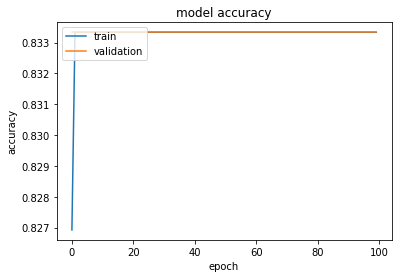

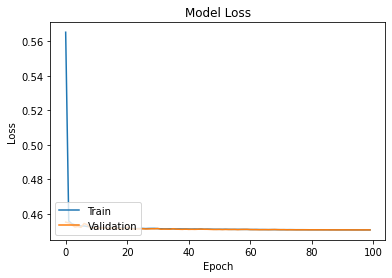

In [0]:
plt.plot(history_inception.history['accuracy'])
plt.plot(history_inception.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_inception.history['loss'])
plt.plot(history_inception.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_Incept, validation_acc_Incept = model_inception.evaluate_generator(validation_genrator_inception, steps=10)
print( 'validation_acc:', validation_acc_Incept)

validation_acc: 0.6602209806442261


In [0]:
test_loss_incept, test_acc_incept = model_inception.evaluate_generator(test_generator_inception, steps=30)
print('test_acc:', test_acc_Res_1)

test_acc: 0.5438596606254578


### **Inception with regularization**

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen_inception_1 = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen_inception_1 = ImageDataGenerator(rescale=1./255)
test_datagen_inception_1 = ImageDataGenerator(rescale=1./255)

train_generator_inception_1 = train_datagen_inception_1.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator_inception_1 = validation_datagen_inception_1.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator_inception_1 = test_datagen_inception_1.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  batch_size = 171,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
K.clear_session()
x_1 = layers.Flatten()(inception_model.output)
x_1 = layers.Dense(256, activation='relu')(x_1)
x_1 = layers.Dropout(0.5)(x_1)
x_1 = layers.Dense(1, activation='sigmoid')(x_1)

model_inception_1 = Model(inception_model.input, x_1)
model_inception_1.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
callback_K = ModelCheckpoint(filepath = 'my_best_model.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_L = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
history_inception_1 = model_inception_1.fit_generator(train_generator_inception_1,
                                                  steps_per_epoch=100,
                                                  epochs=100,
                                                  callbacks=[callback_K, callback_L], 
                                                  validation_data=validation_genrator_inception_1,
                                                  validation_steps=valid_images.shape[0] / 10                             
                                                )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.6619 - accuracy: 0.8043
Epoch 00001: val_loss improved from inf to 0.45602, saving model to my_best_model.hdf5
100/100 [==============================] - 23s 230ms/step - loss: 0.6619 - accuracy: 0.8043 - val_loss: 0.4560 - val_accuracy: 0.8333
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.4739 - accuracy: 0.8333
Epoch 00002: val_loss improved from 0.45602 to 0.45555, saving model to my_best_model.hdf5
100/100 [==============================] - 20s 197ms/step - loss: 0.4738 - accuracy: 0.8333 - val_loss: 0.4556 - val_accuracy: 0.8333
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.4704 - accuracy: 0.8333
Epoch 00003: val_loss improved from 0.45555 to 0.45449, saving model to my_best_model.hdf5
100/100 [==============================] - 19s 192ms/step - loss: 0.4704 - accuracy: 0.8333 - va

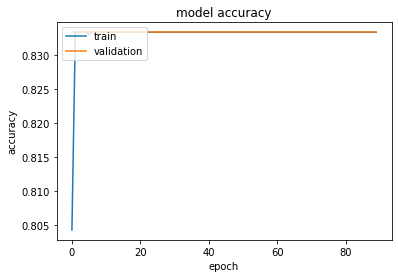

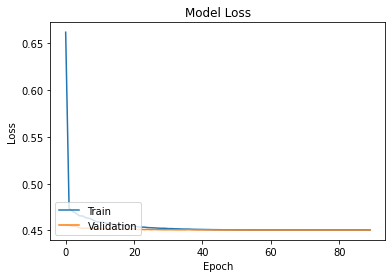

In [0]:
plt.plot(history_inception_1.history['accuracy'])
plt.plot(history_inception_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_inception_1.history['loss'])
plt.plot(history_inception_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_Incept_1, validation_acc_Incept_1 = model_inception_1.evaluate_generator(validation_genrator_inception_1, steps=10)
print( 'validation_acc:', validation_acc_Incept_1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
validation_acc: 0.8333333730697632


In [0]:
test_loss_incept_1, test_acc_incept_1 = model_inception_1.evaluate_generator(test_generator_inception_1, steps=30)
print('test_acc:', test_acc_incept_1)

test_acc: 0.8333333134651184


##**DenseNet121**


In [0]:
from tensorflow.keras.applications.densenet import DenseNet121
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(140,90,3))

for layer in densenet.layers:
    layer.trainable = False

29089792/29084464 [==============================] - 0s 0us/step


In [0]:
densenet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 90, 3)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 146, 96, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 70, 45, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 70, 45, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [0]:
train_datagen_denseNet = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen_denseNet = ImageDataGenerator(rescale=1./255)
test_datagen_denseNet = ImageDataGenerator(rescale=1./255)

train_generator_denseNet = train_datagen_denseNet.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator_denseNet = validation_datagen_denseNet.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator_denseNet = test_datagen_denseNet.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  batch_size = 171,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
K.clear_session()
denseNet_model = models.Sequential()
denseNet_model.add(densenet)
denseNet_model.add(layers.Flatten())
denseNet_model.add(layers.Dense(256, activation='relu'))
denseNet_model.add(layers.Dense(6, activation='sigmoid'))

densenet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 90, 3)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 146, 96, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 70, 45, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 70, 45, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [0]:
callback_dense_1 = ModelCheckpoint(filepath = 'my_best_model.hdf1', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_dense_2 = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
denseNet_model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
history_densenet = denseNet_model.fit_generator(train_generator_denseNet, 
                                    steps_per_epoch=100,
                                    epochs=100,
                                    callbacks=[callback_dense_1, callback_dense_2],
                                    validation_data=validation_genrator_denseNet,
                                    validation_steps=valid_images.shape[0] / 10
                                  )

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.7627
Epoch 00001: val_loss improved from inf to 0.09222, saving model to my_best_model.hdf1
100/100 [==============================] - 24s 239ms/step - loss: 0.2565 - accuracy: 0.7627 - val_loss: 0.0922 - val_accuracy: 0.9061
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0870 - accuracy: 0.9167
Epoch 00002: val_loss did not improve from 0.09222
100/100 [==============================] - 18s 179ms/step - loss: 0.0863 - accuracy: 0.9170 - val_loss: 0.0966 - val_accuracy: 0.9061
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9327
Epoch 00003: val_loss did not improve from 0.09222
100/100 [==============================] - 18s 178ms/step - loss: 0.0738 - accuracy: 0.9327 - val_loss: 0.0976 - val_accuracy: 0.8950
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0680 - accuracy: 0.9397
Epoch 00004: val_loss

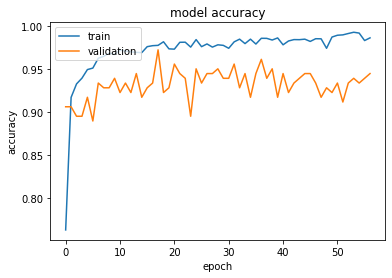

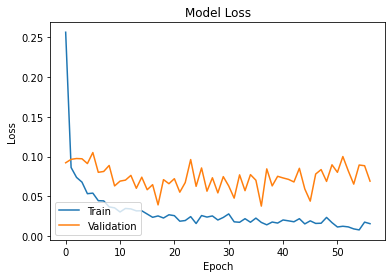

In [0]:
plt.plot(history_densenet.history['accuracy'])
plt.plot(history_densenet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_densenet.history['loss'])
plt.plot(history_densenet.history['val_loss'])
plt.title('Model Loss') 
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_dense, validation_acc_dense = denseNet_model.evaluate_generator(validation_genrator_denseNet, steps=10)
print( 'validation_acc:', validation_acc_dense)

validation_acc: 0.9447513818740845


In [0]:
test_loss_dense, test_acc_dense = denseNet_model.evaluate_generator(test_generator_denseNet, steps=30)
print('test_acc:', test_acc_dense)

test_acc: 0.9649122953414917


### **DenseNet with Regularizer**


In [0]:
train_datagen_denseNet_1 = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen_denseNet_1 = ImageDataGenerator(rescale=1./255)
test_datagen_denseNet_1 = ImageDataGenerator(rescale=1./255)

train_generator_denseNet_1 = train_datagen_denseNet_1.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator_denseNet_1 = validation_datagen_denseNet_1.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator_denseNet_1 = test_datagen_denseNet_1.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  batch_size = 171,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
K.clear_session()
denseNet_model_1 = models.Sequential()
denseNet_model_1.add(densenet)
denseNet_model_1.add(layers.Flatten())
denseNet_model_1.add(layers.Dense(256, activation='relu'))
denseNet_model_1.add(layers.Dropout(0.5))
denseNet_model_1.add(layers.Dense(6, activation='sigmoid'))

densenet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 90, 3)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 146, 96, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 70, 45, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 70, 45, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [0]:
callback_dense_3 = ModelCheckpoint(filepath = 'my_best_model.hdf1', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_dense_4 = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
denseNet_model_1.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
history_densenet_1 = denseNet_model_1.fit_generator(train_generator_denseNet, 
                                    steps_per_epoch=100,
                                    epochs=100,
                                    callbacks=[callback_dense_3, callback_dense_4],
                                    validation_data=validation_genrator_denseNet,
                                    validation_steps=valid_images.shape[0] / 10
                                  )

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.3436 - accuracy: 0.6950
Epoch 00001: val_loss improved from inf to 0.10787, saving model to my_best_model.hdf1
100/100 [==============================] - 21s 206ms/step - loss: 0.3436 - accuracy: 0.6950 - val_loss: 0.1079 - val_accuracy: 0.8785
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.8472
Epoch 00002: val_loss improved from 0.10787 to 0.09794, saving model to my_best_model.hdf1
100/100 [==============================] - 19s 187ms/step - loss: 0.1505 - accuracy: 0.8472 - val_loss: 0.0979 - val_accuracy: 0.8895
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.8824
Epoch 00003: val_loss improved from 0.09794 to 0.07758, saving model to my_best_model.hdf1
100/100 [==============================] - 18s 183ms/step - loss: 0.1205 - accuracy: 0.8824 - val_loss: 0.0776 - val_accuracy: 0.9171
Epoch 4/100
100/100 [=================

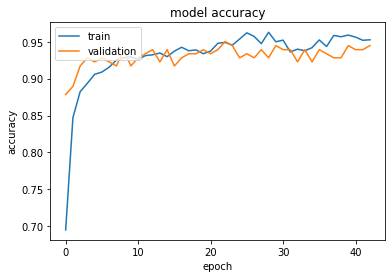

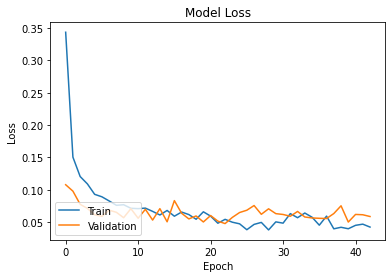

In [0]:
plt.plot(history_densenet_1.history['accuracy'])
plt.plot(history_densenet_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_densenet_1.history['loss'])
plt.plot(history_densenet_1.history['val_loss'])
plt.title('Model Loss') 
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_dense_1, validation_acc_dense_1 = denseNet_model_1.evaluate_generator(validation_genrator_denseNet_1, steps=10)
print( 'validation_acc:', validation_acc_dense_1)

validation_acc: 0.9447513818740845


In [0]:
test_loss_dense_1, test_acc_dense_1 = denseNet_model_1.evaluate_generator(test_generator_denseNet_1, steps=30)
print('test_acc:', test_acc_dense_1)

test_acc: 0.9356725215911865


##**Fine Tuning**

### VGG16 with the Dropout Layer, has better perfomance on Validation Accuracy by 0.04. 

### ResNet 50 without Dropout Layer, has better performance on Validation Accuracy

### Inception V3 

In [0]:
vgg16_fine_tuned = VGG16(weights='imagenet', include_top = False, input_shape=(140,90,3))

In [0]:
vgg16_fine_tuned.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 140, 90, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 140, 90, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 140, 90, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 70, 45, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 70, 45, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 70, 45, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 35, 22, 128)       0     

In [0]:
vgg16_fine_tuned.trainable = True

set_trainable = False
for layer in vgg16_fine_tuned.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
train_datagen_VGG16_ft = ImageDataGenerator(rotation_range=40,
                               width_shift_range=0.4,
                               height_shift_range=0.4,
                               shear_range=0.4,
                               zoom_range=0.4,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen_VGG16_ft = ImageDataGenerator(rescale=1./255)
test_datagen_VGG16_ft = ImageDataGenerator(rescale=1./255)

train_generator_VGG16_ft = train_datagen_VGG16_ft.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    batch_size = 50,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator_VGG16_ft = validation_datagen_VGG16_ft.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator_VGG16_ft = test_datagen_VGG16_ft.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  batch_size = 171 ,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
K.clear_session()
vgg16_fine_tuned_model = models.Sequential()
vgg16_fine_tuned_model.add(vgg16_fine_tuned)
vgg16_fine_tuned_model.add(layers.Flatten())
vgg16_fine_tuned_model.add(layers.Dense(256, activation='relu'))
vgg16_fine_tuned_model.add(layers.Dropout(0.5))
vgg16_fine_tuned_model.add(layers.Dense(6, activation='sigmoid'))

vgg16_fine_tuned_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 15,765,062
Trainable params: 8,129,798
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
callback_M = ModelCheckpoint(filepath = 'my_best_model.hdf7', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_N = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
vgg16_fine_tuned_model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
history_vgg16_fine_tuned = vgg16_fine_tuned_model.fit_generator(train_generator_VGG16_ft, 
                                    steps_per_epoch=100,
                                    epochs=100,
                                    callbacks=[callback_M, callback_N],
                                    validation_data=validation_genrator_VGG16_ft,
                                    validation_steps=valid_images.shape[0] / 10
                                  )

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.3684 - accuracy: 0.4278
Epoch 00001: val_loss improved from inf to 0.21209, saving model to my_best_model.hdf7
100/100 [==============================] - 36s 365ms/step - loss: 0.3684 - accuracy: 0.4278 - val_loss: 0.2121 - val_accuracy: 0.6961
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.2213 - accuracy: 0.6719
Epoch 00002: val_loss improved from 0.21209 to 0.16890, saving model to my_best_model.hdf7
100/100 [==============================] - 36s 356ms/step - loss: 0.2213 - accuracy: 0.6719 - val_loss: 0.1689 - val_accuracy: 0.7514
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.7599
Epoch 00003: val_loss improved from 0.16890 to 0.11859, saving model to my_best_model.hdf7
100/100 [==============================] - 36s 363ms/step - loss: 0.1749 - accuracy: 0.7599 - val_loss: 0.1186 - val_accuracy: 0.7956
Epoch 4/100
100/100 [=================

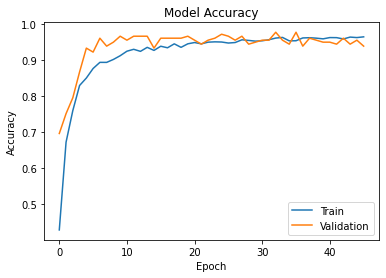

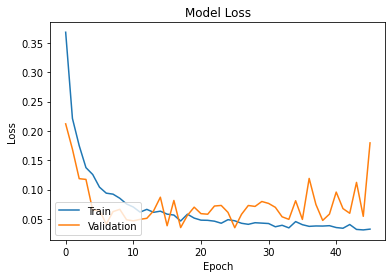

In [0]:
plt.plot(history_vgg16_fine_tuned.history['accuracy'])
plt.plot(history_vgg16_fine_tuned.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history_vgg16_fine_tuned.history['loss'])
plt.plot(history_vgg16_fine_tuned.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_vgg16_ft, validation_acc_vgg16_ft = vgg16_fine_tuned_model.evaluate( validation_genrator_VGG16_ft, steps=20, verbose=1)
print( 'validation_acc:', validation_acc_vgg16_ft)

    116/Unknown - 52s 444ms/step - loss: 0.1796 - accuracy: 0.9392

KeyboardInterrupt: ignored

In [0]:
test_loss_aug_vgg16_ft, test_acc_vgg_16_ft = vgg16_fine_tuned_model.evaluate(test_generator_VGG16_ft, steps=30)
print(test_acc_vgg_16_ft)

30/30 [==============================] - 12s 398ms/step - loss: 0.0813 - accuracy: 0.9591
0.9590643048286438


In [0]:
densenet_ft = DenseNet121(weights='imagenet', include_top=False, input_shape=(140,90,3))

In [0]:
densenet_ft.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 90, 3)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 146, 96, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 70, 45, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 70, 45, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [0]:
densenet_ft.trainable = True

set_trainable = False
for layer in densenet_ft.layers:
  if layer.name == 'conv5_block16_1_conv':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
train_datagen_dense_ft = ImageDataGenerator(rotation_range=40,
                               width_shift_range=0.4,
                               height_shift_range=0.4,
                               shear_range=0.4,
                               zoom_range=0.4,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen_dense_ft = ImageDataGenerator(rescale=1./255)
test_datagen_dense_ft = ImageDataGenerator(rescale=1./255)

train_generator_dense_ft = train_datagen_dense_ft.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    batch_size = 50,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator_dense_ft = validation_datagen_dense_ft.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator_dense_ft = test_datagen_dense_ft.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  batch_size = 171 ,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
K.clear_session()
denseNet_model_ft = models.Sequential()
denseNet_model_ft.add(densenet_ft)
denseNet_model_ft.add(layers.Flatten())
denseNet_model_ft.add(layers.Dense(256, activation='relu'))
denseNet_model_ft.add(layers.Dense(6, activation='sigmoid'))

densenet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 90, 3)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 146, 96, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 70, 45, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 70, 45, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [0]:
callback_5 = ModelCheckpoint(filepath = 'my_best_model.hdf7', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_6 = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
denseNet_model_ft.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
history_dense_ft = denseNet_model_ft.fit_generator(train_generator_dense_ft, 
                                    steps_per_epoch=100,
                                    epochs=100,
                                    callbacks=[callback_5, callback_6],
                                    validation_data=validation_genrator_dense_ft,
                                    validation_steps=valid_images.shape[0] / 10
                                  )

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.2666 - accuracy: 0.7403
Epoch 00001: val_loss improved from inf to 0.07418, saving model to my_best_model.hdf7
100/100 [==============================] - 37s 368ms/step - loss: 0.2666 - accuracy: 0.7403 - val_loss: 0.0742 - val_accuracy: 0.9337
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.8963
Epoch 00002: val_loss improved from 0.07418 to 0.04913, saving model to my_best_model.hdf7
100/100 [==============================] - 34s 337ms/step - loss: 0.0991 - accuracy: 0.8963 - val_loss: 0.0491 - val_accuracy: 0.9558
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9164
Epoch 00003: val_loss improved from 0.04913 to 0.03187, saving model to my_best_model.hdf7
100/100 [==============================] - 34s 335ms/step - loss: 0.0783 - accuracy: 0.9164 - val_loss: 0.0319 - val_accuracy: 0.9724
Epoch 4/100
100/100 [=================

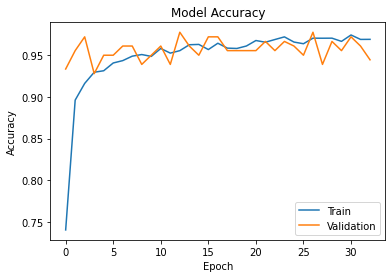

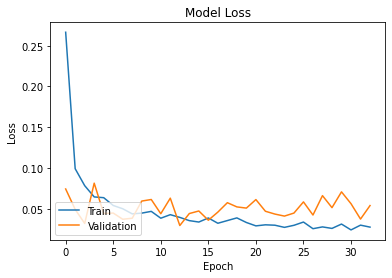

In [0]:
plt.plot(history_dense_ft.history['accuracy'])
plt.plot(history_dense_ft.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history_dense_ft.history['loss'])
plt.plot(history_dense_ft.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_dense_ft, validation_acc_dense_ft = denseNet_model_ft.evaluate( validation_genrator_dense_ft, steps=20, verbose=1)
print( 'validation_acc:', validation_acc_dense_ft)

20/20 [==============================] - 7s 330ms/step - loss: 0.0538 - accuracy: 0.9448
validation_acc: 0.9447513818740845


In [0]:
test_loss_dense_ft, test_acc_dense_ft = denseNet_model_ft.evaluate(test_generator_dense_ft, steps=30)
print(test_acc_dense_ft)

30/30 [==============================] - 10s 317ms/step - loss: 0.0832 - accuracy: 0.9357
0.9356725215911865
